In [1]:
## import libraries
import sys
import glob
import re

import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

# cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, plot_terrain
from utils import roundPartial, select_months_ds
import customcmaps as ccmap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## Load Basin watershed file
fp = path_to_data + 'downloads/UpperCo/Upper_Colorado_River_Basin_Boundary.shp'
basin = gpd.read_file(fp, crs="EPSG:4326") # have to manually set the projection
basin

## get list of HUC8s within Upper Colorado River Basin
# test = gpd.clip(polys, basin)
# test.plot()

,EXT_ID,EXT_TYP_ID,NAME,geometry
0,9389,5.00,Upper Colorado Region,"POLYGON ((-106.65587 40.51559, -106.65376 40.5..."


In [4]:
## load continental divide shapefile
fp = path_to_data + 'downloads/continental_divide_shapefile/pw312bv3382.shp'
divide = gpd.read_file(fp, crs="ESPG:4326")

## load HU2 shapefile for regions 10, 11, 13, 14
region_lst = [10, 11, 13, 14]
WBD_lst = []
for i, region in enumerate(region_lst):
    fp = path_to_data + 'downloads/WBD_HU2_{0}/Shape/WBDHU2.shp'.format(region)
    WBD = gpd.read_file(fp, crs="ESPG:4326")
    WBD_lst.append(WBD)

## load watershed shapefile
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:4326") # have to manually set the projection

In [27]:

def calc_fraction(ds1, ds2, varname, thres):
    
    ## total precip
    wy_prec = ds2.prec.groupby(ds2.water_year).sum(dim="date")
    
    ## get all the dates from the trajectory dataset where criteria is met
    ar_days = ds1.where(ds1[varname] >= float(thres), drop=True).start_date.values
    
    ## select those dates from precip dataset
    ds2 = ds2.sel(date=ar_days)

    ## calculate WY fraction of extreme precip
    wy_ar_prec = ds2.prec.groupby(ds2.water_year).sum(dim="date")
    wy_frac = (wy_ar_prec / wy_prec)*100
    try:
        frac = wy_frac.sel(water_year=2023)
        frac = float(frac.values)

    except KeyError:
        frac = 0.0
        
    
    return frac


def calc_HUC8_AR_contribution(PRISM, HUC8_ID_lst, thres, varname):
    
    da = xr.DataArray(data=np.array([0, 0, 0, 0, 0, 0]),
                      dims=["ar_scale"],
                      coords=dict(ar_scale=(["ar_scale"], np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0]))))
    
    frac_lst = []
    ARscale_lst = []
    
    for i, HUC8_ID in enumerate(HUC8_ID_lst):
        # print(i, HUC8_ID)
        # subset the PRISM data to the current HUC8
        tmp = PRISM.sel(HUC8=str(HUC8_ID))
        tmp = tmp.where(tmp.extreme == 1, drop=True)

        ## load final trajectory dataset
        fname = '/expanse/nfs/cw3e/cwp140/preprocessed/ERA5_trajectories/combined_extreme_AR/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
        traj = xr.open_dataset(fname)
        traj = select_months_ds(traj, start_mon, end_mon, 'start_date')

        try:
            frac = calc_fraction(traj, tmp, varname, thres)

            # get the number of times AR scale for each trajectory
            ARscale = traj.groupby("ar_scale").count().ar

        except ValueError:
            ## no AR days
            frac = 0
            ARscale = da

        frac_lst.append(frac)
        ARscale_lst.append(ARscale)
        
    return frac_lst, ARscale_lst

In [28]:
start_mon = 1
end_mon = 12

## load PRISM watershed precip dataset
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
## get select months
PRISM = select_months_ds(PRISM, start_mon, end_mon, 'date')
## add water year to data as coordinate
water_year = (PRISM.date.dt.month >= 10) + PRISM.date.dt.year
PRISM.coords['water_year'] = water_year
HUC8_ID_lst = PRISM.HUC8.values ## get list of HUC8 IDs


thres_lst = [1, 1, 1]
var_lst = ['tARget', 'ar_scale', 'ar']
var_lst2 = ['tARget_std', 'ar_scale_std', 'ar_std']

AR_scale_lst_final = []
for i, (thres, varname, varname2) in enumerate(zip(thres_lst, var_lst, var_lst2)):
    print('{0}, {1}'.format(varname, thres))
    frac_lst, ARscale_lst = calc_HUC8_AR_contribution(PRISM, HUC8_ID_lst, thres, varname)
    ## concat ARscale dataframes
    ds = xr.concat(ARscale_lst, pd.Index(HUC8_ID_lst, name="HUC8"))
    # AR_scale_lst_final.append(ds.sum('HUC8'))
    AR_scale_lst_final.append(ds)
    ## now attach to the geopandas dataframe
    polys[varname] = frac_lst
    print(polys[varname].max())

tARget, 1
100.0
ar_scale, 1
100.0
ar, 1
100.0


In [29]:
HUC8_ID_lst = [14050001, ## upper yampa
               # 14050005, ## upper white
               # 14050002, ## lower yampa
               # 14080104, ## animas (San Juans),
               # 14030002, ## upper dolores
               13010001, ## rio grande headwaters
               # 11020002, ## arkansas - Pueblo Reservoir
               # 10190005 ## St. Vrain (Boulder)
               # 14030005, ## 'Upper Colorado-Kane Springs'
               10190002, ## 'Upper South Platte'
               11020001 ## Arkansas Headwaters
              ]
idx = (polys.HUC8 == str(HUC8_ID_lst[0])) | (polys.HUC8 == str(HUC8_ID_lst[1])) | (polys.HUC8 == str(HUC8_ID_lst[2])) | (polys.HUC8 == str(HUC8_ID_lst[3]))
tmp =  polys[idx]
tmp

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,States,HUC8,Name,Shape_Leng,Shape_Area,geometry,tARget,ar_scale,ar
20,21,{E174065A-2AA4-49D1-B443-F550A60C869D},None,None,None,None,2016-07-27,0,"1,676,731.25","6,785.50",CO,14050001,Upper Yampa,5.10,0.72,"POLYGON ((-106.77828 40.90596, -106.77765 40.9...",10.12,32.07,20.28
49,50,{19D18F78-BA7C-4A1E-A1F6-DA996B233880},None,None,None,None,2017-04-17,0,"1,961,578.79","7,938.23",CO,11020001,Arkansas Headwaters,7.02,0.82,"POLYGON ((-106.21421 39.38309, -106.21368 39.3...",0.00,0.00,0.00
86,87,{A8098AC6-DFD5-48AA-A352-9057E09913D8},None,None,None,None,2017-09-19,0,"883,590.41","3,575.77",CO,13010001,Rio Grande Headwaters,3.82,0.37,"POLYGON ((-106.96559 37.97355, -106.96542 37.9...",70.76,70.76,58.35
87,88,{AAFC1326-6A7C-49C0-BC17-9573AE42BC21},None,None,None,None,2016-10-11,0,"1,183,831.16","4,790.80",CO,10190002,Upper South Platte,4.29,0.50,"POLYGON ((-105.04506 39.76261, -105.04449 39.7...",19.58,19.58,7.57


In [30]:
polys.sort_values(by=['ar_scale'])

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,States,HUC8,Name,Shape_Leng,Shape_Area,geometry,tARget,ar_scale,ar
29,30,{7652BA85-83A1-44B7-A1E1-4B21DE182AF7},None,None,None,None,2016-10-18,0,"889,443.15","3,599.45","CO,WY",10190009,Crow,4.65,0.38,"POLYGON ((-105.12268 41.28111, -105.12234 41.2...",0.00,0.00,0.00
49,50,{19D18F78-BA7C-4A1E-A1F6-DA996B233880},None,None,None,None,2017-04-17,0,"1,961,578.79","7,938.23",CO,11020001,Arkansas Headwaters,7.02,0.82,"POLYGON ((-106.21421 39.38309, -106.21368 39.3...",0.00,0.00,0.00
75,76,{05DBE4C0-3058-4283-A8C2-796166FB1C06},None,None,None,None,2012-06-11,0,"1,012,643.12","4,098.02",CO,13010003,San Luis,4.27,0.42,"POLYGON ((-106.03348 38.45448, -106.03318 38.4...",0.00,0.00,0.00
28,29,{944695E4-151C-4E8B-948E-2A1F94A36F1A},None,None,None,None,2016-10-11,0,"594,176.20","2,404.55",CO,11020003,Fountain,2.95,0.25,"POLYGON ((-104.93889 39.13518, -104.93876 39.1...",0.00,0.00,0.00
30,31,{1544FB0D-C9F5-4467-BC05-073DEADCDB66},None,None,None,None,2016-10-18,0,"756,830.04","3,062.79","CO,NE,WY",10190015,Upper Lodgepole,4.32,0.33,"POLYGON ((-104.82331 41.41504, -104.82224 41.4...",0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,{666364B6-D9DB-4C44-8CBD-3092083EFC8D},None,None,None,None,2017-09-19,0,"2,195,832.52","8,886.23","CO,NM",14080101,Upper San Juan,9.01,0.90,"POLYGON ((-107.53180 37.70543, -107.53152 37.7...",62.40,73.49,73.49
34,35,{6D501CFE-4431-4914-AE14-C2EE513C1785},None,None,None,None,2012-06-11,0,"458,851.88","1,856.91","CO,UT",14080202,McElmo,2.45,0.19,"POLYGON ((-108.74189 37.60335, -108.74079 37.6...",80.04,80.04,64.31
65,66,{9AEDE168-54E8-42B2-A580-F7EC70997690},None,None,None,None,2012-06-11,0,"490,805.55","1,986.22",CO,14020001,East-Taylor,2.62,0.21,"POLYGON ((-106.70218 39.05557, -106.70201 39.0...",71.65,80.85,80.85
62,63,{A5C1EEA1-80EE-49EC-9473-DF41AD004E7F},None,None,None,None,2017-09-20,0,"2,082,907.01","8,429.23","CO,NM",13020101,Upper Rio Grande,6.44,0.85,"POLYGON ((-105.47640 37.19316, -105.47512 37.1...",100.00,100.00,100.00


In [31]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
ext1 = [-111., -100., 35.5, 42.5] # extent of CO
dx = np.arange(ext1[0],ext1[1]+2,2)
dy = np.arange(ext1[2]-.5,ext1[3]+1,1)

# # make a colormap that has land and ocean clearly delineated and of the
# # same length (256 + 256)
# colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
# colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
# all_colors = np.vstack((colors_undersea, colors_land))
# terrain_map = mcolors.LinearSegmentedColormap.from_list(
#     'terrain_map', all_colors)
# # make the norm:  Note the center is offset so that the land has more
# # dynamic range:
# divnorm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=1, vmax=3000)


wc_rgb = (86./255., 105./255., 166./255.) # color for water features
wc_cmyk = (48., 37., 0., 35.)


0 0 tARget
1 1 ar_scale
2 2 ar


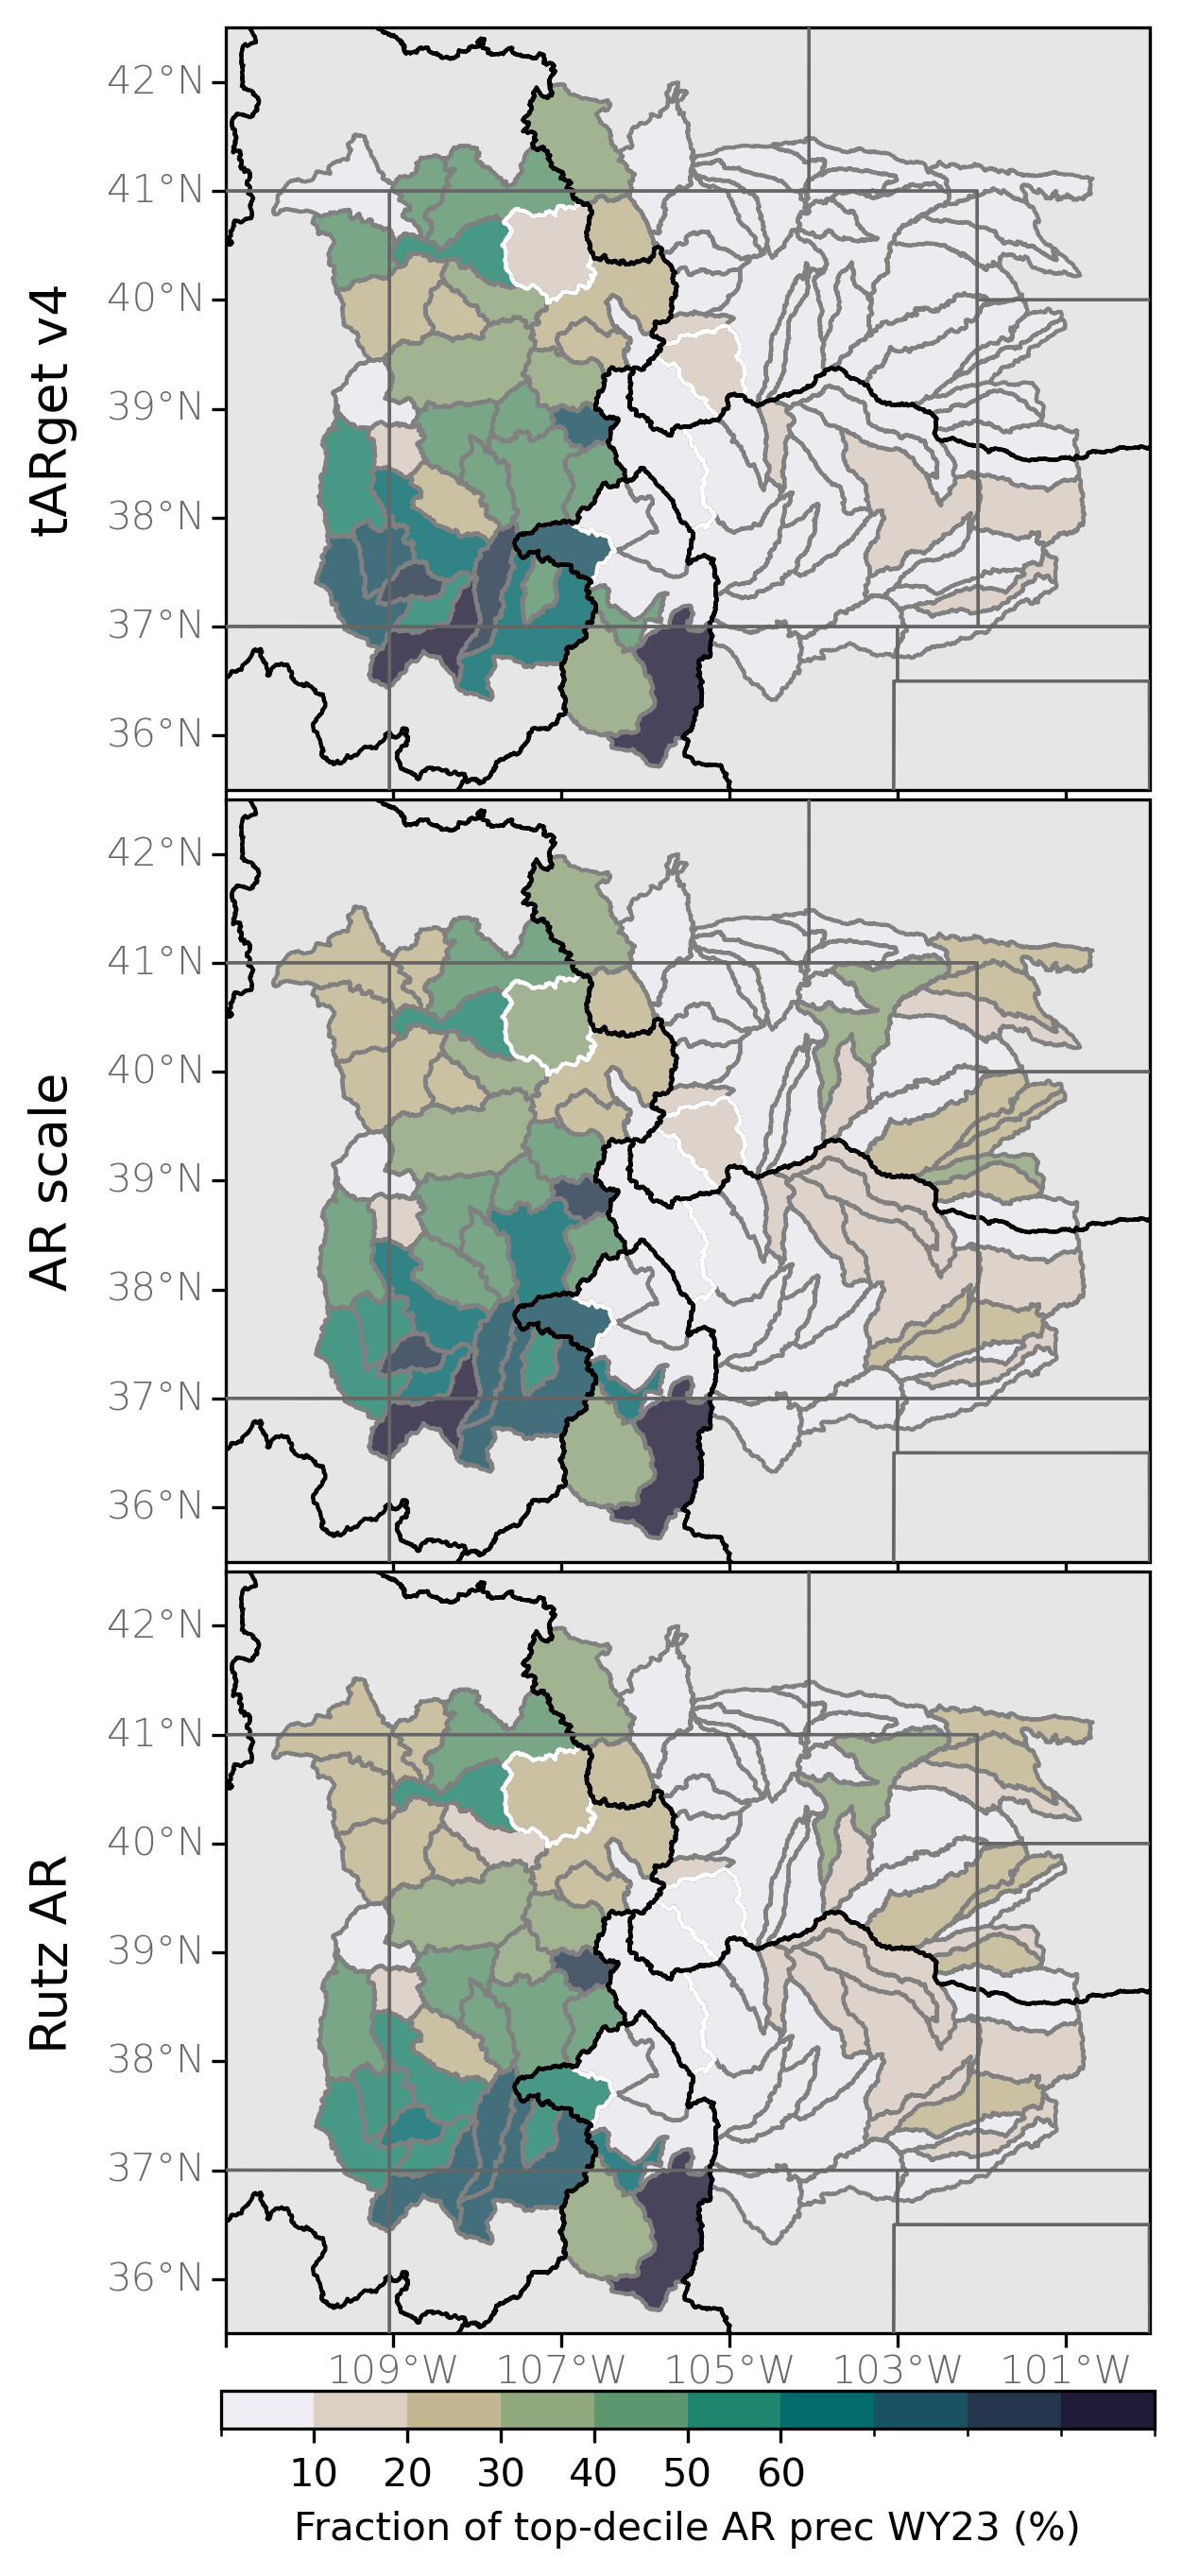

In [35]:
# Create figure
fig = plt.figure(figsize=(4.25, 11))
fig.dpi = 300
fname = path_to_figs + 'choropleth_map_portrait_UCRC'
fmt = 'png'

nrows = 5
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 0.05, 0.05], width_ratios = [1], wspace=0.02, hspace=0.02)
## use gs[rows index, columns index] to access grids

# Add color bar axis
cbax = plt.subplot(gs[-1,0]) # colorbar axis
lbl_lst = ['tARget v4', 'AR scale', 'Rutz AR']
var_lst = ['tARget', 'ar_scale', 'ar']
row_idx = [0, 1, 2]
b_lons = [False, False, True]

for k, varname in enumerate(var_lst):
    print(k, row_idx[k], varname)
    ## Add axis for plot
    ax = fig.add_subplot(gs[row_idx[k],0], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False, bottom_lons=b_lons[k], mask_ocean=False, coastline=False)

    ## topo with gray shading
    # cs = plot_terrain(ax, ext1)

    # add choropleth watershed fraction
    cbarticks = [10, 20, 30, 40, 50, 60]
    lgnd_kwds={"label": "Fraction of top-decile AR prec WY23 (%)", "orientation": "horizontal", "ticks": cbarticks}
    cmap, norm, bnds = ccmap.cmap_segmented(cmo.rain, np.arange(0, 110, 10))
    cf = polys.plot(ax=ax, column=varname, cmap=cmap, vmin=0, vmax=100, norm=norm, alpha=0.8, legend=True, cax=cbax, legend_kwds=lgnd_kwds)
    polys.plot(ax=ax, edgecolor='grey', color='None', zorder=98)

    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8, zorder=199)

    ## add in four focus watersheds
    tmp.plot(ax=ax, edgecolor='white', color='None', zorder=99)
    # basin.plot(ax=ax, edgecolor='white', color='None', zorder=99)

    ## add in region watershed shape
    for j, WBD in enumerate(WBD_lst):
        WBD.plot(ax=ax, edgecolor='k', color='None', zorder=100)

    ## add continental divide
    # divide.plot(ax=ax, color='tab:blue', zorder=99)

    # ax.set_title(lbl_lst[k], loc='left', fontsize=14)
    ax.text(-0.16, 0.5, lbl_lst[k], va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor', fontsize=13,
                    transform=ax.transAxes)
        
fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

In [ ]:
# Create figure
fig = plt.figure(figsize=(8, 8))
fig.dpi = 300
fname = path_to_figs + 'choropleth_map_single_panel'
fmt = 'png'

nrows = 2
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05], width_ratios = [1], wspace=0.1, hspace=0.1)
## use gs[rows index, columns index] to access grids

# Add color bar axis
cbax = plt.subplot(gs[-1,0]) # colorbar axis
lbl_lst = ['AR scale']
var_lst = ['ar_scale']


for k, varname in enumerate(var_lst):
    ## Add axis for plot
    ax = fig.add_subplot(gs[0,0], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False, mask_ocean=False, coastline=False)

    ## topo with gray shading
    # cs = plot_terrain(ax, ext1)

    # add choropleth watershed fraction
    lgnd_kwds={"label": "Fraction of top-decile precipitation related to ARs (%)", "orientation": "horizontal"}
    cmap, norm, bnds = ccmap.cmap_segmented(cmo.rain, np.arange(0, 80, 10))
    cf = polys.plot(ax=ax, column=varname, cmap=cmap, vmin=0, vmax=100, norm=norm, alpha=0.8, legend=True, cax=cbax, legend_kwds=lgnd_kwds)
    polys.plot(ax=ax, edgecolor='grey', color='None', zorder=98)

    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8, zorder=199)

    ## add in four focus watersheds
    tmp.plot(ax=ax, edgecolor='white', color='None', zorder=99)
    # basin.plot(ax=ax, edgecolor='white', color='None', zorder=99)

    # ## add continental divide
    # divide.plot(ax=ax, color='k', zorder=99)

    ## add in region watershed shape
    for j, WBD in enumerate(WBD_lst):
        WBD.plot(ax=ax, edgecolor='k', color='None', zorder=100)
        

    ax.set_title('AR Contribution to Top-Decile Precipitation (Jan 2000–Dec 2023)', loc='left', fontsize=14)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

In [ ]:
AR_scale_lst_final[2].values